In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_long_from_analysis,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
from amftrack.util.plot import gridplot
import logging
from datetime import timedelta
logging.getLogger().setLevel(logging.WARNING)
plt.style.use('presentation.mplstyle')

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_analysis_folders = get_analysis_folders()
plates = [
"3_20220426",
"12_20220502",
"16_20220419",
"480_20221205",
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
folders,time_plate_info_long = get_time_plate_info_long_from_analysis(analysis_folders,use_saved=False)
time_plate_info = time_plate_info.replace(-1.0,np.nan)
time_plate_info_long = time_plate_info_long.replace(-1.0,np.nan)
width = 1.6
height = 1
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,use_saved=False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,use_saved=False)

In [4]:
for index in range(20):
    # time_plate_info_long[f"rhon-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]*time_plate_info[f"ring_density_incr-100_index-{index}"]
    time_plate_info[f"ring_active_tips_density_incr-100_index-{index}"] = time_plate_info_long[f"ring_active_tips_density_incr-100_index-{index}"]
    time_plate_info[f"ring_density_incr-100_index-{index}-new"] = time_plate_info_long[f"ring_density_incr-100_index-{index}-new"]


In [5]:
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Supplementary material\extended_data_figures\FigureS2"

In [6]:
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}

In [45]:
shifts = {int(plate.split('_')[0]) : 0 for plate in plates}
shifts = {30: 20, 32: 30, 33: 20,3 : 80,16:9,12 : 20,480:100,28: 30}
shifts

{30: 20, 32: 30, 33: 20, 3: 80, 16: 9, 12: 20, 480: 100, 28: 30}

0 days 00:00:00
0 days 00:01:00
0 days 00:53:00
0 days 00:00:00
0 days 00:01:00
0 days 00:53:00
0 days 00:00:00
0 days 00:00:00
0 days 00:10:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
2023-07-26 19:31:51,497-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


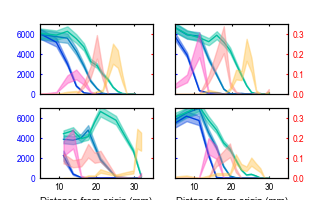

In [49]:
cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")
suffix = ""
suffix = "-new"
max_indexes = {int(plate.split('_')[0]) : 15 for plate in plates}
ncols =2
fig,axs = gridplot(len(plates),ncols = ncols,subh = height,subw = width,sharex=True,sharey=True)
timestep_lists = {}
for j,ax in enumerate(axs):
    if j<len(plates):
        ax2 = ax.twinx()
        plate = plates[j]
        plate = int(plate.split('_')[0])
        table = time_plate_info.loc[time_plate_info["Plate"]==plate]
        table = table.sort_values(by="datetime")
        table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]

        # table = table.dropna()
        ts = list(table['timestep'])
        table = table.set_index('timestep',drop=False)
        table_err = table_err.set_index('timestep',drop=False)

        ts = list(table.index)
        ts.sort()
        dic = {}
        ax.axis([5,35,0,7000])


        # popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info_long,plate,timesteps,max_indexes,lamb = -1,C =1000)
        # t0 = max(0,popt_f[-1]/popt_f[0])
        shift = shifts[plate]
        i0 = shift
        timesteps_select = []
        for delta in [0,30,60]:
            target_value = table["time_since_begin"].iloc[i0] + timedelta(hours=delta)
            differences = abs(table["time_since_begin"] - target_value)
            closest_index = differences.idxmin()
            closest_row = table.loc[closest_index]
            print(differences[closest_index])
            timesteps_select.append(closest_row["timestep"])
        # timesteps = table.loc[table['time_since_begin_h'].between(shift,shift+400)]
        # timesteps = timesteps.loc[timesteps['timestep']<=timestep[plate]]
        # timestep_lists[plate] = timesteps['time_since_begin_h']
        # indexes = range(0,len(timesteps),len(timesteps)//5) 
        # indexes = list(indexes)[2:5]
        # timesteps_select = timesteps.iloc[indexes]['timestep']
        
        for i,t in enumerate(timesteps_select):
     #     ax.set_yscale("log")

            maxL = np.sqrt(1900)
            X = np.linspace(0,maxL,100)
            incr = 100
            def density(x,suffix = ''):
                area = x**2
                index = int(area//incr)
                column = f"ring_density_incr-100_index-{index}{suffix}"
                if len(suffix) == 0:
                    return(float(table[column][t]))
                else:
                    return(float(table_err[column][t]))
            xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
            yvalues = [density(x,suffix) for x in xvalues]
            xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if not(np.isnan(y))])

            dic[t] = {}
            dic[t]['distance_origin'] = xvalues
            dic[t]['ring_density'] = yvalues
            xvalues = np.array(xvalues)
            yvalues = np.array(yvalues) 
            X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
            Y = yvalues
            line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
            lines.append(line)
            scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap((i+1)/4),label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
            table = table.sort_values('area_sep_comp')
            xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
            err = 0*ys + 500*ys/np.max(ys)
            ax.fill_between(xs, ys-err, ys+err,color=cmap((i+1)/4),alpha = 0.4)
            # draw_error_band(ax, xs, ys,err,color=cmap((len(timesteps)-i)/len(timesteps)),alpha = 0.6)
            #     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]/2000, facecolor=cmap((len(timesteps)-i)/len(timesteps)), edgecolor="white") for j,x in enumerate(xs)]

        #     for ellipse in ellipses:
        #         ax.add_artist(ellipse)
            xs = np.linspace(np.min(X),np.max(X),1000)
            ts = [table['time_since_begin_h'][t] for x in xs]
            xt = np.array((xs,ts))
            def density(x):
                area = x**2
                index = int(area//incr)
                column = f"ring_active_tips_density_incr-100_index-{index}"
                return(float(table_err[column][t]))
            xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
            yvalues = [density(x) for x in xvalues]

            xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues) if not(np.isnan(y))])
            dic[t]['tip_density'] = yvalues
            xvalues = np.array(xvalues)
            yvalues = np.array(yvalues) 
            X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
            Y = yvalues
            # scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color=cmap2((i+1)/len(timesteps)))

            line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1))}
            lines.append(line)
            xs = np.linspace(np.min(X),np.max(X),1000)
            ts = [table['time_since_begin_h'][t] for x in xs]
            xt = np.array((xs,ts))
            # ax2.plot(xs,dwave(xt,*popt_f2),color=cmap2((len(timesteps)-i)/len(timesteps)))
            xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
            err = abs(ys)/4

            # err = 0*ys + 80
            ax2.fill_between(xs, ys-err, ys+err,color=cmap2((i+1)/4),alpha = 0.4)
            # ax2.plot(xs,ys,color=cmap2((i+1)/len(timesteps_select)))
            if j//ncols == len(plates)//ncols-1:
                ax.set_xlabel('Distance from origin (mm)')
            # if j%ncols == 0:
            #     ax.set_ylabel('Network density ($\mu m.mm^{-2}$)') 
            ax2.set_ylim((0,0.35))
            # if j%ncols == ncols-1:
            #     ax2.set_ylabel('Active tip density ($mm^{-2}$)')
            if j%ncols < ncols-1:
                ax2.set_yticklabels([])
            ax.tick_params(axis='y', colors='blue')
            ax2.tick_params(axis='y', colors='red')
            right = 0.90
            top = 0.90
            fontsize = 10
    # if plate==16:
        # break
    # break
# plt.tight_layout()
# fig.text(0.5, 0.0, 'Distance from origin (mm)', ha='center', va='center',size = 20)
# fig.text(0.04, 0.5, 'Network density ($\mu m.mm^{-2}$)', ha='center', va='center', rotation='vertical',size = 20)
# plt.tight_layout()


plt.savefig(os.path.join(path_figure,'FigureS2B_agg.pdf'), transparent=True, bbox_inches='tight')

In [48]:
timesteps_select

[100, 114, 129]

2023-07-25 07:08:57,082-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


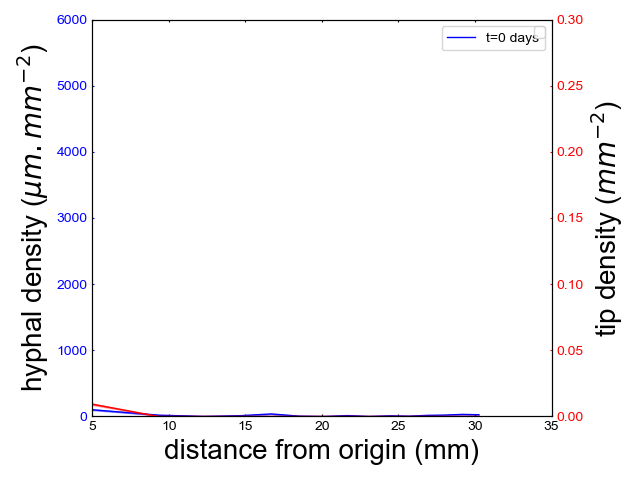

In [179]:
# max_indexes = {plate : 20 for plate in plate_select}

plate = 3
timesteps= range(0,timestep[plate]) 

# popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]
table = table.replace(np.nan,-1)
table = table.set_index('timestep',drop=False)
table_err = table_err.set_index('timestep',drop=False)

ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}

timesteps = range(10,timestep[plate]) 
# timesteps = range(3,4) 

lines = []
for i,t in enumerate(timesteps):
    plt.close("all")
    fig, ax = plt.subplots()
    ax.axis([5,35,0,6000])
    ax.set_xlabel('distance from origin (mm)',size =20)
    ax.set_ylabel('hyphal density ($\mu m.mm^{-2}$)',size =20) 
    ax2=ax.twinx()
    ax2.set_ylim((0,0.30))
    ax2.set_ylabel('tip density ($mm^{-2}$)',size =20)
    ax.tick_params(axis='y', colors='blue',labelsize = 10)
    ax.tick_params(axis='x',labelsize = 10)
    
    ax2.tick_params(axis='y', colors='red',labelsize = 10)
    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-new"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    errvalues = [density(x)/20 for x in xvalues]
    
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    scat1 = ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color='blue',label=f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    table = table.sort_values('area_sep_comp')
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    err = errvalues
    # err = 0*ys + 80
    ax.fill_between(xs, ys-err, ys+err,color='blue',alpha = 0.4)
    # draw_error_band(ax, xs, ys,err,color=cmap((len(timesteps)-i)/len(timesteps)),alpha = 0.6)
    #     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]/2000, facecolor=cmap((len(timesteps)-i)/len(timesteps)), edgecolor="white") for j,x in enumerate(xs)]

#     for ellipse in ellipses:
#         ax.add_artist(ellipse)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/pd.Timedelta(days=1)}
    lines.append(line)
    # ax.plot(xs,wave(xt,*popt_f),color=cmap((len(timesteps)-i)/len(timesteps)))
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table_err[column][t]))
    def err(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}-bootstd"
        return(2*float(table_err[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    errvalues = [density(x)/20 for x in xvalues]
    
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    scat2 = ax2.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,color='red')
    
    line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1))}
    lines.append(line)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    # ax2.plot(xs,dwave(xt,*popt_f2),color=cmap2((len(timesteps)-i)/len(timesteps)))
    xs, ys  = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues
    # err = np.std(ys)*abs(ys)/0.10
    err = errvalues
    
    # err = 0*ys + 80
    ax2.fill_between(xs, ys-err, ys+err,color='red',alpha = 0.4)
#     ellipses = [Ellipse((x,ys[j]), 0.5, np.std(ys)*ys[j]/0.10, facecolor=cmap2((len(timesteps)-i)/len(timesteps)), edgecolor="white") for j,x in enumerate(xs)]

#     for ellipse in ellipses:
#         ax2.add_artist(ellipse)
    # lines_legends.append((scat1, scat2))
    # labels.append(f't={int(table["time_since_begin"][t]/pd.Timedelta(days=1))} days')
    

#     line = {"type" : "fit tip density","x" : xs,"y" : dwave(xt,*popt_f2),"time_h":int(table["time_since_begin"][t]//pd.Timedelta(days=1)) }
#     lines.append(line)
    right = 0.90
    top = 0.90
    fontsize = 10
    ax.legend()
    ax2.legend()
    plt.tight_layout()
    plt.savefig(f'Video/frame{t}.png')

    break

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:55: RuntimeWarning: overflow encountered in exp
  return C * (1 / (1 + np.exp(lamb * (t0 - t))))
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


2023-07-25 07:12:40,557-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


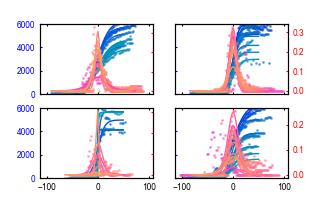

In [189]:
cmap1 = mpl.cm.get_cmap("spring")
cmap2 = mpl.cm.get_cmap("winter")
maxi = 10
max_area=50
Csstips = {}
Css = {}

ncols = 2
lambsstips = {}
fig,axs = gridplot(len(plates),ncols = ncols,subh = height,subw = width,sharex=True,sharey=True)
dss = {}
dssC = {}

for j,ax in enumerate(axs):
    if j<len(plates):
    # if j==2:
        
        ax2 = ax.twinx()
        plate = plates[j]
        plate = int(plate.split('_')[0])
        timesteps= range(0,timestep[plate]) 
        table = time_plate_info.loc[time_plate_info["Plate"] == plate].copy()
        table_err = time_plate_info_long.loc[time_plate_info_long["Plate"]==plate]
        table = table.set_index('timestep',drop=False)
        table_err = table_err.set_index('timestep',drop=False)
        shift = shifts[plate]
        timesteps = table.loc[table['time_since_begin_h'].between(shift,shift+400)]
        timesteps = timesteps.loc[timesteps['timestep']<=timestep[plate]]["timestep"]
        timestep_max =np.max(timesteps)
        table = table.loc[table["timestep"]<=timestep_max]
        table = table.set_index("timestep")
        ts = []
        ys = []
        ys2 = []
        Cs = []
        Cserror = []
        t0serror = []
        lambs = []
        indexes = []
        t0s = []
        ds = []
        dsC = []
        Cstips = []
        lambstip = []

        for index in range(1, maxi):
            column = f"ring_density_incr-100_index-{index}{suffix}"
            column2 = f"ring_active_tips_density_incr-100_index-{index}"
            if len(suffix)>0:
                table[column] = table_err[column]
                table[column2] = table_err[column2]
                
            area = np.sqrt(table["area_sep_comp"][0] + 100 * index)

            sorted_column = table.sort_values(by=column,ascending=True)
            # if len(sorted_column.loc[sorted_column[column] >= 400])>2:
            if len(sorted_column.loc[sorted_column[column] >= 1000])>3:


                start = sorted_column.loc[sorted_column[column] >= 1000]["time_since_begin"].iloc[2]
                select = table.loc[(table["time_since_begin"]/pd.Timedelta(hours=1)).between(start/pd.Timedelta(hours=1)-80,start/pd.Timedelta(hours=1)+80)]
                select = select.loc[((select["time_since_begin"]>=start)&(select[column]>=1000)) | (select["time_since_begin"]<start)&(select[column]<=1000)].copy()
                select[f"time_since_begin_{index}"] = (
                    select["time_since_begin"] - start
                )/pd.Timedelta(hours = 1)

                selection_fit = select
                xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]


                popt0, pcov = curve_fit(
                    S,
                    xis,
                    yis,
                    bounds=([0, 0, -np.inf], 3 * [np.inf]),
                    p0=[1, 4000, 0],
                )
                lamb, C, t0 = list(popt0)
                select[f"time_since_begin_{index}"] = select[f"time_since_begin_{index}"] - t0

                ax.scatter(
                    select[f"time_since_begin_{index}"],
                    select[column],
                    alpha=0.5,
                    color=cmap2(area / max_area),
                )

                xis,yis = selection_fit[f"time_since_begin_{index}"],selection_fit[column]
                data = np.array((xis,yis))
                def statistic(x,y):
                    try:
                        popt0, pcov = curve_fit(
                        S,
                        x,
                        y,
                        bounds=([0, 0, -np.inf], 3 * [np.inf]),
                        p0=[1, 1, 0],
                    )
                        return(popt0[2])
                    except:
                        return(C)
                t0s.append(t0+start/pd.Timedelta(hours=1))

                Cs.append(C)
                dsC.append(int(area / np.sqrt((np.pi / 2))))

                lambs.append(lamb)
                indexes.append(index)
                x = np.linspace(-50, 50, 100)
                ax.plot(
                    x,
                    S(x + t0, lamb, C, t0),
                    color=cmap2(area / max_area),
                    label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
                )
                # try:
                x = selection_fit[f"time_since_begin_{index}"].to_numpy()
                y = selection_fit[column2].to_numpy()
                not_nan_indices = np.where(~np.isnan(y))

                # Perform interpolation using np.interp
                y_interpolated = np.interp(x, x[not_nan_indices], y[not_nan_indices])
                popt1, _ = curve_fit(
                    dS,
                    x,
                    y_interpolated,
                    bounds=([0, 0, -np.inf], 3 * [np.inf]),
                    p0=[0.2, 0.5, 0],
                )
                ax2.scatter(
                    select[f"time_since_begin_{index}"]-t1,
                    select[column2],
                    alpha=0.5,
                    color=cmap1(area / max_area),
                )
                lamb, C, t1 = list(popt1)
                # if lamb>0.15:
                Cstips.append(C)
                lambstip.append(lamb)
                ds.append(int(area / np.sqrt((np.pi / 2))))


                ax2.plot(
                    x,
                    dS(x +t1, lamb, C, t1),
                    color=cmap1(area / max_area),
                    label=f"d = {int(area / np.sqrt((np.pi / 2)))}mm",
            )
                # except (RuntimeError, ValueError) as e:
                #     pass
                # break

        # ax2.set_xlim((-60, 60))
        # ax2.set_ylim((0, 0.25))
        ax.set_ylim((0, 6000))

        # ax.set_ylabel("Network density ($\mu m.mm^{-2}$)")
        # ax2.set_xlabel("Shifted time ($h$)")
        # ax2.set_ylabel("Active tips density ($mm^{-2}$)")
        ax.tick_params(axis="y", colors="blue")
        ax2.tick_params(axis="y", colors="red")
        if j%ncols < ncols-1:
            ax2.set_yticklabels([])
        Csstips[plate] = Cstips
        Css[plate] = Cs

        lambsstips[plate] = lambstip
        dss[plate] = ds
        dssC[plate] = dsC
    # break
    
# plt.tight_layout()


plt.savefig(os.path.join(path_figure,'FigureS2C_agg.pdf'), transparent=True, bbox_inches='tight')


In [15]:
suffix = "-new"
# suffix = ""



In [30]:
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)
time_hypha_info['time_since_begin_h_float'] = time_hypha_info['time_since_begin_h']/(1e3*3600)

In [31]:
time_hypha_info['time_since_begin_h_float']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
26489    216.0
26490    216.0
26491    216.0
26492    216.0
26493    216.0
Name: time_since_begin_h_float, Length: 26494, dtype: float64

In [32]:
timestep_select

timestep
27      80.433333
28      82.433333
29      84.433333
30      86.433333
31      88.416667
          ...    
140    323.166667
141    325.150000
142    437.533333
143    439.533333
144    443.533333
Name: time_since_begin_h, Length: 118, dtype: float64

2023-07-25 07:28:14,377-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


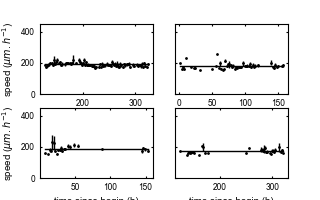

In [192]:
hull_speeds_dic = {}
hull_time_dic = {}
ncols = 2
fig,axs = gridplot(len(plates),ncols = ncols,subh = height,subw = width)
ax_list = list(axs)
maxi = 140
for j in range(len(plates)):
    plate_id = plates[j]
    plate = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]
    timestep_select = timestep_lists[plate]
    data,dy,select_movements = get_average_time_data(int(plate_id),time_hypha_info,2)
    hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
    # all_hyphae_hull = np.concatenate(hyphae_hull)
    if len(hyphae_hull)>0:
        label = 'hull pusher'
        for time in timestep_select:
            select = time_hypha_plate.loc[time_hypha_plate['time_since_begin_h_float'].astype(int)==int(time)]
            if len(select)>0:
                t = int(select["timestep"].iloc[0])
                # select = select.loc[select['end'].isin(all_hyphae_hull)]
                
                select = select.loc[select['end'].isin(hyphae_hull[max(t-1,0)]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
                select = select.loc[select['speed'].between(150,350)]
                if len(select)>0:
                    time = select['time_since_begin_h_float'].iloc[0]
                    # if time<=100:
                    ax.scatter(select['time_since_begin_h_float'].iloc[0],np.mean(select["speed"]),color='black')
                    ax.errorbar(select['time_since_begin_h_float'].iloc[0],np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
                    label = None
                    hull_speeds.append(np.mean(select["speed"]))
                    hull_time.append(select['time_since_begin_h_float'].iloc[0])
            # break

        # ax.plot(data.index/pd.Timedelta(hours = 1),data)
        # ax.errorbar(data.index,data, yerr=dy,label='average')
        # ax.set_xlim(0,150)
        ax.set_ylim(0,450)

        # ax.legend()
        # ax.set_title(f'{plate}')
        # ax.set_xlabel('time since begin (h)')
        # ax.set_ylabel('speed ($\mu m.h^{-1}$)')
        if j//ncols == len(plates)//ncols-1:
            ax.set_xlabel('time since begin (h)')
        if j%ncols == 0:
            ax.set_ylabel('speed ($\mu m.h^{-1}$)') 
        if j%ncols !=0:
            ax.set_yticklabels([])
        ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
                color="black",
                label= f'mean hull pusher speed {int(np.nanmean(hull_speeds))}$\pm${int(2*np.nanstd(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
        # ax.legend()
        hull_speeds_dic[plate] = hull_speeds
        hull_time_dic[plate] = hull_time
    # break
# plt.savefig(f'Figure/FigureS2E.svg')    
plt.savefig(os.path.join(path_figure,'FigureS2E_agg.pdf'), transparent=True, bbox_inches='tight')


In [193]:
hull_speeds_dic

{3: [187.5272095738,
  175.8880961916,
  181.0341688969,
  186.93168098243333,
  191.20227389895,
  200.151785636225,
  197.03390571885,
  183.8596080696333,
  220.0785906361,
  193.5472222209,
  203.90255775383332,
  216.15471250925,
  201.71558800575002,
  203.78559251068,
  187.74800241684,
  191.3043379626,
  190.99610155506664,
  200.220691956475,
  201.7919715434,
  196.48124808875,
  199.59267017509998,
  194.38776232415998,
  201.4108019739,
  220.7887397636,
  199.52873507308,
  219.80392558901667,
  204.9772465131286,
  200.75727733894288,
  184.0716493695286,
  200.01963397248,
  218.76978298031432,
  189.3932908502833,
  204.2273679813167,
  188.81763924319998,
  189.30456274916665,
  187.92222574483998,
  186.08405482630002,
  180.54020222479,
  178.19950072155999,
  176.84910749079998,
  165.7283943066,
  172.98658784319093,
  176.44311387806667,
  190.4048545989125,
  175.7023517568143,
  190.46532827753748,
  181.25242388838333,
  183.53538413808002,
  184.5385356969333

2023-07-25 07:12:51,038-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


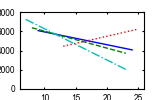

In [190]:
fig,ax = plt.subplots(figsize=(width,height))
# Define a list of line styles
line_styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5)), (0, (5, 5)), (0, (3, 5, 1, 5, 1, 5)),
              (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 10))]

# Define a list of line colors
line_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange', 'purple', 'brown', 'teal', 'pink']

def statistic(ds,Cs):
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    color = plt.gca().lines[-1].get_color()
    ax.plot(ds,np.array(ds)*a+b,color = color, alpha = 0.01)
    return(a)

tot_ds = []
tot_Cs=[]
for j,plate in enumerate(plates):
    plate = int(plate.split('_')[0])
    Cs = Css[plate]
    ds = dssC[plate]
    tot_ds+=ds
    tot_Cs+=Cs
    # ax.plot(ds,Cs,alpha = 0.2,color = line_colors[j])
    
    X = sm.add_constant(ds, prepend=False)
    model = sm.OLS(Cs,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(ds,np.array(ds)*a+b,label=plate,linestyle = line_styles[j],color = line_colors[j])
    data = np.array((ds,Cs))
    
#     n_resamples=1000
#     std = scipy.stats.bootstrap(data,statistic,
#                                 vectorized = False,
#                                 method="basic",
#                                 n_resamples = n_resamples,
#                                 paired= True).standard_error
# X = sm.add_constant(tot_ds, prepend=False)
# model = sm.OLS(tot_Cs,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# ax.plot(tot_ds,np.array(tot_ds)*a+b,color = 'black')
df = pd.DataFrame((tot_ds,tot_Cs)).transpose()
df.columns = ('distance','saturation density')
data = np.array((tot_ds,tot_Cs))
# n_resamples=10000
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error

# data = df.groupby('distance').mean()
# ax.plot(data.index,data,label="average",color='black',linewidth=10,alpha = 0.5)    
# ax.legend()
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density \n ($\mu m.mm^{-2}$)')
# ax.set_ylim(0,1000)

# plt.tight_layout()
# plt.savefig(f'Figure/FigureS1Bsubset.svg')    
ax.set_ylim(0,8000)
plt.savefig(os.path.join(path_figure,'FigureS2D_agg.pdf'), transparent=True, bbox_inches='tight')


2023-07-25 07:12:57,433-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


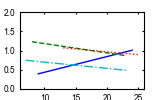

In [191]:
fig, ax = plt.subplots(figsize=(width,height))

for j,plate in enumerate(plates):
    plate = int(plate.split('_')[0])
    Cstips = np.array(Csstips[plate])
    if len(Cstips)>1:
        ds = dss[plate]
        # ax.scatter(ds,Cstips)
        x = np.array(ds)
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(Cstips,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x,x*a+b,linestyle = line_styles[j],color = line_colors[j])
# ax.set_ylim(0,1)
# fig, ax = plt.subplots()

# for plate in plates[6:]:
#     plate = int(plate.split('_')[0])
#     Cstips = Csstips[plate]
#     ax.plot(range(len(Cstips)),Cstips,alpha = 0.3)
#     # x = np.array(range(len(Cstips)))
#     # X = sm.add_constant(x, prepend=False)
#     # model = sm.OLS(Cstips,X)
#     # res = model.fit()
#     # a,b = res.params[0],res.params[1]
#     # ax.plot(x,x*a+b)
ax.set_ylim(0,2)
ax.set_xlabel('distance from origin (mm)')

ax.set_ylabel("peak value ($mm^{-2}$)")
plt.savefig(os.path.join(path_figure,'FigureS2F_agg.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
for plate in plate_select:
# for plate in [938]:
    t0s = t0ss[plate][:maxis[plate]]
    ds = dss[plate][:maxis[plate]]
    X = sm.add_constant(t0s, prepend=False)
    model = sm.OLS(ds,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    x = np.array(t0s)+b/a
    ax.plot(x,np.array(t0s)*a+b,label = f"{plate} : speed = {int(1000*a)}$\mu m.h^{-1}$")
    ax.scatter(x,ds)
    
ax.legend()
ax.set_ylabel('distance from center (mm)')
ax.set_xlabel('time of wave crossing (hours)')
plt.tight_layout()
plt.savefig(f'Figure/FigureS1C2.svg')    

In [ ]:
strains = ["'A5'","'A5sp3'"]
plates = [plate for plate in folders['unique_id'].unique() if folders.loc[folders['unique_id']==plate].iloc[0]['strain'] in strains]
treatments = ["'001P100N100C'","'001P100N'"]
plates = [plate for plate in plates if folders.loc[folders['unique_id']==plate].iloc[0]['medium'] in treatments]
plates.remove(87720220419)
plates.remove(40320221005)
plates.remove(90720220321)

In [ ]:
# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plates),ncols = ncols,subh = 4.0,subw = 8)
maxis = {plate :12 for plate in plates}
for i in range(len(plates)):
    plate=plates[i]
    ax = axs[i]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[int(str(plate)[:-8])],ax,maxi =maxis[plate],unique_id = True)
    meancurves[plate]=meancurve
    meancurves2[plate]=meancurve2
    Css[plate] = Cs
    lambss[plate] = lambs
    dss[plate] = ds
    t0ss[plate] = t0s

In [ ]:
# plt.close('all')
fig, ax = plt.subplots()

ax2 = ax.twinx()

for plate in plates:
    meancurve = meancurves[plate]
    meancurve2 = meancurves2[plate]
    ax.plot(meancurve.index,meancurve,label=int(str(plate)[:-8]))
    ax2.plot(meancurve.index,meancurve2,label=int(str(plate)[:-8]),linestyle="dashed")
ax.set_xlim((-30,30))
ax2.set_ylim((0,0.2))

ax.set_ylabel('network density ($\mu m.mm^{-2}$)')
ax.set_xlabel('shifted time ($h$)')
ax2.set_ylabel('active tips density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
plt.legend()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
# plates = [52,152,94,102,83,84,792,76]

for plate in plates:
    if int(str(plate)[:-8]) not in [91,89,56]:
        Cs = Css[plate]
        ds = dss[plate]
        tot_ds+=ds
        tot_Cs+=Cs
        ax.plot(ds,Cs,label = int(str(plate)[:-8]))
df = pd.DataFrame((tot_ds,tot_Cs)).transpose()
df.columns = ('distance','saturation density')
data = df.groupby('distance').mean()
ax.plot(data.index,data,label="average",color='black',linewidth=10,alpha = 0.5)    
ax.legend()
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density ($\mu m.mm^{-1}$)')
plt.tight_layout()